# Goal
In this rapid times medical professionals wants to get the most accurate and efficient knowledge of diffeerent papers which were published from long ago. Due to such situation there are so many papers are there which we taken as dataset. There is more than 55000 pubished papers and articles inn different journals from all around the world. Our task iis to make clustering thing from which we can make best out of it and categories them in proper clusters.

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np

In [ ]:
metaData = pd.read_csv('/content/drive/My Drive/metadata.csv', dtype={'pubmed_id': str, 'Microsoft academic paper id': str, 'doi': str})

In [ ]:
# Checking null values
metaData.isna().sum()

cord_uid                           0
sha                            13374
source_x                           0
title                            158
doi                             3340
pmcid                           8746
pubmed_id                      14340
license                            0
abstract                        9230
publish_time                       8
authors                         2279
journal                         5242
Microsoft Academic Paper ID    51434
WHO #Covidence                 50630
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8604
url                              302
dtype: int64

In [ ]:
metaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52398 entries, 0 to 52397
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     52398 non-null  object 
 1   sha                          39024 non-null  object 
 2   source_x                     52398 non-null  object 
 3   title                        52240 non-null  object 
 4   doi                          49058 non-null  object 
 5   pmcid                        43652 non-null  object 
 6   pubmed_id                    38058 non-null  object 
 7   license                      52398 non-null  object 
 8   abstract                     43168 non-null  object 
 9   publish_time                 52390 non-null  object 
 10  authors                      50119 non-null  object 
 11  journal                      47156 non-null  object 
 12  Microsoft Academic Paper ID  964 non-null    float64
 13  WHO #Covidence  

Extracting files as some files are very large to process.

In [ ]:
# EExtracting zip data
import zipfile
zipfile.ZipFile('/content/drive/My Drive/custom_license.zip', 'r').extractall('./')
zipfile.ZipFile('/content/drive/My Drive/biorxiv_medrxiv.zip', 'r').extractall('./')
zipfile.ZipFile('/content/drive/My Drive/noncomm_use_subset.zip', 'r').extractall('./')
zipfile.ZipFile('/content/drive/My Drive/comm_use_subset.zip', 'r').extractall('./')

In [ ]:
# Because of JSON files we need to hold it in glob type of object
# So that we can process it further
import glob
folder = glob.glob('./biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/*.json')
folder1 = glob.glob('./comm_use_subset/comm_use_subset/pdf_json/*.json')
folder2 = glob.glob('./comm_use_subset/comm_use_subset/pmc_json/*.json')
folder3 = glob.glob('./custom_license/custom_license/pdf_json/*.json')
folder4 = glob.glob('./custom_license/custom_license/pmc_json/*.json')
folder5 = glob.glob('./noncomm_use_subset/comm_use_subset/pdf_json/*.json')
folder6 = glob.glob('./noncomm_use_subset/comm_use_subset/pmc_json/*.json')

In [ ]:
folder = folder1 + folder2 + folder3 + folder4 + folder5 + folder6
all_json = folder

In [ ]:
len(all_json)

53984

In [ ]:
import json
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

1817050ed534376723c94abc3b5496beea55ed5b: Background: In Sweden, knowledge about the role of enteropathogenic Escherichia coli in neonatal calf diarrhea and the occurrence of antimicrobial resistance in E. coli from young calves is largely un... Neonatal calf diarrhea (NCD) is a major disease worldwide when calves are reared intensively, and constitute substantial cost in terms of calf mortality, opportunity costs for labor and capital, veter...


In [ ]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [ ]:
dict_ = {'paper_id': [], 'doi': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

In [ ]:
len(metaData)

52398

This is data cleaning helper function which process data from JSON files and converts them into nice pandas dataframe structure tow otk with. Converts each attributes to it's respective column names.

In [ ]:
meta_df = metaData
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 53984
Processing index: 5398 of 53984
Processing index: 10796 of 53984
Processing index: 16194 of 53984
Processing index: 21592 of 53984
Processing index: 26990 of 53984
Processing index: 32388 of 53984
Processing index: 37786 of 53984
Processing index: 43184 of 53984
Processing index: 48582 of 53984
Processing index: 53980 of 53984


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,1817050ed534376723c94abc3b5496beea55ed5b,10.1186/1751-0147-54-2,"Background: In Sweden, knowledge about the rol...",Neonatal calf diarrhea (NCD) is a major diseas...,"de Verdier, Kerstin. Nyman, Ann. Greko,<br>...",Antimicrobial resistance and virulence<br>fac...,Acta Vet Scand,"Background: In Sweden, knowledge about the<br..."
1,0700c01d64e50ef5ae5943328bd734718cf614f4,10.1371/journal.pone.0014520,The spread of infectious disease via commercia...,The potential for international airline passen...,"Hwang, Grace M.. DiCarlo, Anthony A.. Lin, ...",An Analysis on the Detection of Biological<br...,PLoS One,The spread of infectious disease via<br>comme...
2,b47b54d0d0a92245735b5b88ed1c3634574772d5,10.3390/v10040152,The recent 2014-2016 West African Ebola virus ...,Ebola virus (EBOV) and Marburg virus (MARV) be...,"Cui, Qinghua. Du, Ruikun. Anantpadma, Manu....",Identification of Ellagic Acid from Plant<br>...,Viruses,The recent 2014-2016 West African Ebola virus...
3,8e4a1132b0301964add6af40ca83b222d7f6d9e3,10.1371/journal.pone.0008326,The ecological radiation of mammals to inhabit...,Mammals are arguably the most ecologically div...,"Zhao, Huabin. Ru, Binghua. Teeling, Emma C....",Rhodopsin Molecular Evolution in Mammals<br>I...,PLoS One,The ecological radiation of mammals to inhabi...
4,b04c8cddba2dfb4f953daac916d936924976392d,10.1186/s12879-019-4616-9,Background: Among pediatric patients hospitali...,Readmission of patients initially hospitalized...,"Wang, Le. Feng, Zhishan. Shuai, Jinfeng. L...",Risk factors of 90-day rehospitalization<br>f...,BMC Infect Dis,Background: Among pediatric patients<br>hospi...


In [ ]:
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,1817050ed534376723c94abc3b5496beea55ed5b,10.1186/1751-0147-54-2,"Background: In Sweden, knowledge about the rol...",Neonatal calf diarrhea (NCD) is a major diseas...,"de Verdier, Kerstin. Nyman, Ann. Greko,<br>...",Antimicrobial resistance and virulence<br>fac...,Acta Vet Scand,"Background: In Sweden, knowledge about the<br..."
1,0700c01d64e50ef5ae5943328bd734718cf614f4,10.1371/journal.pone.0014520,The spread of infectious disease via commercia...,The potential for international airline passen...,"Hwang, Grace M.. DiCarlo, Anthony A.. Lin, ...",An Analysis on the Detection of Biological<br...,PLoS One,The spread of infectious disease via<br>comme...
2,b47b54d0d0a92245735b5b88ed1c3634574772d5,10.3390/v10040152,The recent 2014-2016 West African Ebola virus ...,Ebola virus (EBOV) and Marburg virus (MARV) be...,"Cui, Qinghua. Du, Ruikun. Anantpadma, Manu....",Identification of Ellagic Acid from Plant<br>...,Viruses,The recent 2014-2016 West African Ebola virus...
3,8e4a1132b0301964add6af40ca83b222d7f6d9e3,10.1371/journal.pone.0008326,The ecological radiation of mammals to inhabit...,Mammals are arguably the most ecologically div...,"Zhao, Huabin. Ru, Binghua. Teeling, Emma C....",Rhodopsin Molecular Evolution in Mammals<br>I...,PLoS One,The ecological radiation of mammals to inhabi...
4,b04c8cddba2dfb4f953daac916d936924976392d,10.1186/s12879-019-4616-9,Background: Among pediatric patients hospitali...,Readmission of patients initially hospitalized...,"Wang, Le. Feng, Zhishan. Shuai, Jinfeng. L...",Risk factors of 90-day rehospitalization<br>f...,BMC Infect Dis,Background: Among pediatric patients<br>hospi...


Creating visualization supporting columnns so that we can show which type statistics can be used.

In [ ]:
df_covid['abstracrt_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid['body_unique_words'] = df_covid['body_text'].apply(lambda x: len(set(str(x).split())))

In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33205 entries, 0 to 33204
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   paper_id           33205 non-null  object
 1   doi                33026 non-null  object
 2   abstract           33205 non-null  object
 3   body_text          33205 non-null  object
 4   authors            32717 non-null  object
 5   title              33169 non-null  object
 6   journal            33048 non-null  object
 7   abstract_summary   33205 non-null  object
 8   abstracrt_count    33205 non-null  int64 
 9   body_count         33205 non-null  int64 
 10  body_unique_words  33205 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.8+ MB


In [ ]:
df_covid['abstract'].describe(include='all')

count     33205
unique    23796
top            
freq       9359
Name: abstract, dtype: object

In [ ]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     33183
unique    23796
top            
freq       9348
Name: abstract, dtype: object

In [ ]:
df_covid['body_text'].describe(include='all')

count                                                 33183
unique                                                33177
top       The human disease multiple sclerosis (MS) is a...
freq                                                      2
Name: body_text, dtype: object

In [ ]:
# After converting JSON and compiled in Pandas Dataframe format
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstracrt_count,body_count,body_unique_words
0,1817050ed534376723c94abc3b5496beea55ed5b,10.1186/1751-0147-54-2,"Background: In Sweden, knowledge about the rol...",Neonatal calf diarrhea (NCD) is a major diseas...,"de Verdier, Kerstin. Nyman, Ann. Greko,<br>...",Antimicrobial resistance and virulence<br>fac...,Acta Vet Scand,"Background: In Sweden, knowledge about the<br...",352,4594,1402
1,0700c01d64e50ef5ae5943328bd734718cf614f4,10.1371/journal.pone.0014520,The spread of infectious disease via commercia...,The potential for international airline passen...,"Hwang, Grace M.. DiCarlo, Anthony A.. Lin, ...",An Analysis on the Detection of Biological<br...,PLoS One,The spread of infectious disease via<br>comme...,285,6786,1872
2,b47b54d0d0a92245735b5b88ed1c3634574772d5,10.3390/v10040152,The recent 2014-2016 West African Ebola virus ...,Ebola virus (EBOV) and Marburg virus (MARV) be...,"Cui, Qinghua. Du, Ruikun. Anantpadma, Manu....",Identification of Ellagic Acid from Plant<br>...,Viruses,The recent 2014-2016 West African Ebola virus...,215,3808,1363
3,8e4a1132b0301964add6af40ca83b222d7f6d9e3,10.1371/journal.pone.0008326,The ecological radiation of mammals to inhabit...,Mammals are arguably the most ecologically div...,"Zhao, Huabin. Ru, Binghua. Teeling, Emma C....",Rhodopsin Molecular Evolution in Mammals<br>I...,PLoS One,The ecological radiation of mammals to inhabi...,267,5821,1777
4,b04c8cddba2dfb4f953daac916d936924976392d,10.1186/s12879-019-4616-9,Background: Among pediatric patients hospitali...,Readmission of patients initially hospitalized...,"Wang, Le. Feng, Zhishan. Shuai, Jinfeng. L...",Risk factors of 90-day rehospitalization<br>f...,BMC Infect Dis,Background: Among pediatric patients<br>hospi...,212,2386,946


In [ ]:
df_covid.describe()

,abstracrt_count,body_count,body_unique_words
count,33183.000000,33183.000000,33183.000000
mean,155.933882,4774.020010,1444.430974
std,157.892201,6946.562684,1171.338024
min,0.000000,1.000000,1.000000
25%,0.000000,2415.500000,915.000000
50%,155.000000,3706.000000,1256.000000
75%,233.000000,5530.000000,1700.000000
max,4767.000000,260378.000000,35875.000000


In [ ]:
df = df_covid
# Removing to free up space as instance get higher space
del df_covid

In [ ]:
df

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstracrt_count,body_count,body_unique_words
0,1817050ed534376723c94abc3b5496beea55ed5b,10.1186/1751-0147-54-2,"Background: In Sweden, knowledge about the rol...",Neonatal calf diarrhea (NCD) is a major diseas...,"de Verdier, Kerstin. Nyman, Ann. Greko,<br>...",Antimicrobial resistance and virulence<br>fac...,Acta Vet Scand,"Background: In Sweden, knowledge about the<br...",352,4594,1402
1,0700c01d64e50ef5ae5943328bd734718cf614f4,10.1371/journal.pone.0014520,The spread of infectious disease via commercia...,The potential for international airline passen...,"Hwang, Grace M.. DiCarlo, Anthony A.. Lin, ...",An Analysis on the Detection of Biological<br...,PLoS One,The spread of infectious disease via<br>comme...,285,6786,1872
2,b47b54d0d0a92245735b5b88ed1c3634574772d5,10.3390/v10040152,The recent 2014-2016 West African Ebola virus ...,Ebola virus (EBOV) and Marburg virus (MARV) be...,"Cui, Qinghua. Du, Ruikun. Anantpadma, Manu....",Identification of Ellagic Acid from Plant<br>...,Viruses,The recent 2014-2016 West African Ebola virus...,215,3808,1363
3,8e4a1132b0301964add6af40ca83b222d7f6d9e3,10.1371/journal.pone.0008326,The ecological radiation of mammals to inhabit...,Mammals are arguably the most ecologically div...,"Zhao, Huabin. Ru, Binghua. Teeling, Emma C....",Rhodopsin Molecular Evolution in Mammals<br>I...,PLoS One,The ecological radiation of mammals to inhabi...,267,5821,1777
4,b04c8cddba2dfb4f953daac916d936924976392d,10.1186/s12879-019-4616-9,Background: Among pediatric patients hospitali...,Readmission of patients initially hospitalized...,"Wang, Le. Feng, Zhishan. Shuai, Jinfeng. L...",Risk factors of 90-day rehospitalization<br>f...,BMC Infect Dis,Background: Among pediatric patients<br>hospi...,212,2386,946
...,...,...,...,...,...,...,...,...,...,...,...
33200,996a43a78ffb54daad540bed2289376b9ea3306b,10.1016/j.vetimm.2007.12.006,Modulation of defensin expression may be one w...,Birds are important reservoirs of zoonotic pat...,"van Dijk, Albert. Veldhuizen, Edwin J.A.. <b...",Avian defensins,Veterinary Immunology and Immunopathology,Modulation of defensin expression may be one<...,94,6870,2181
33201,897eb33c5ef58d92ff0b68acbcf1ab5f592c1be2,10.1016/j.cyto.2008.09.006,Trafficking and inflammation in airway disease...,Global Initiative for Asthma (GINA) scholars h...,"Taka, Equar. Errahali, Younes J.. Abonyo,<b...",Post-transcriptional silencing of CCR3<br>dow...,Cytokine,Trafficking and inflammation in airway<br>dis...,199,5475,1695
33202,54f98bcddfb59508c278671a79a7d21197c0c536,10.1016/0022-2836(91)90193-a,Protein sequence alignments have become an imp...,General methods for protein sequence compariso...,"Altschul, Stephen F.",Amino acid substitution matrices from an<br>i...,Journal of Molecular Biology,Protein sequence alignments have become an<br...,167,4433,1605
33203,7b8651134661f8aced0b24ab2bb5e54f6b82b94c,10.1016/j.febslet.2013.11.005,The entire repertoire of antibodies in our ser...,Over a Century has passed since the first Nobe...,"Weiss-Ottolenghi, Yael. Gershoni, Jonathan M.",Profiling the IgOme: Meeting the challenge,FEBS Letters,The entire repertoire of antibodies in our<br...,135,4666,1540


In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32398 entries, 0 to 33204
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   paper_id           32398 non-null  object
 1   doi                32398 non-null  object
 2   abstract           32398 non-null  object
 3   body_text          32398 non-null  object
 4   authors            32398 non-null  object
 5   title              32398 non-null  object
 6   journal            32398 non-null  object
 7   abstract_summary   32398 non-null  object
 8   abstracrt_count    32398 non-null  int64 
 9   body_count         32398 non-null  int64 
 10  body_unique_words  32398 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.0+ MB


Library needed to detect language in given papers, also to process non-english papers it something veery hard and gives sometimes very weird output. So to process in such a way we are processing it using only english papers. And to process only english papers we are detecting using this library.

In [ ]:
# Langdetect for detecting languages
# Different papers are published in different languages.
%pip install langdetect

     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=817298db6f1bf938f018cddad3fb888442f2440eb6fb3cd00056f92e6cefea95
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# This helper function detects language of different papers.
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

DetectorFactory.seed = 0

languages = []
for ii in tqdm(range(0, len(df))):
    text = df.iloc[ii]['body_text'].split(" ")
    lang = 'en'
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(' '.join(all_words))
        except Exception as e:
            try:
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = 'unknown'
                pass
    languages.append(lang)

100%|██████████| 32398/32398 [02:26<00:00, 221.71it/s]


Fortunately most of the papers are in english so we can use it to make enough big dataset.

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
print(f'Total: {len(languages)}\n')
pprint(languages_dict)

Total: 32398

{'ca': 2,
 'cy': 3,
 'de': 111,
 'en': 31564,
 'es': 305,
 'fr': 345,
 'it': 15,
 'nl': 39,
 'pl': 2,
 'pt': 12}


In [ ]:
# Papers distribution by their language
# Putting language to against every paper as a column named languages
import matplotlib.pyplot as plt
df['languages'] = languages
dictLang = df['languages'].value_counts().to_dict()
keys = []
values = []
for key, value in dictLang.items():
    keys.append(key)
    values.append(value)

### As we can see significantly that most of the papers are published in english language.

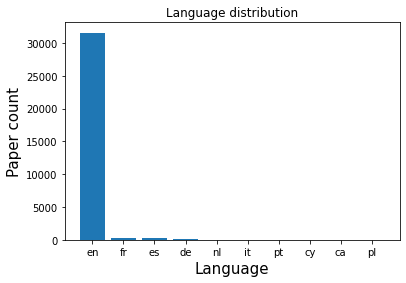

In [ ]:
# Most of the papers are in ennglish
plt.bar(keys, values)
plt.title('Language distribution')
plt.xlabel('Language', fontsize = 15)
plt.ylabel('Paper count', fontsize = 15)
plt.show()

In [ ]:
# For simplicity we are dropping all non-english papers
# We are dropping 840 papers.
dfEnglish = df[df['languages'] == 'en']

In [ ]:
import spacy.cli
# We are taking largest english embedding from spacy library 
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# Download spacy library.
# Spacy refernce: https://spacy.io
# Spacy library is used for NLP projects and there is ton to look at for. 
# We are using it for bascially finding stop words and tokenize use ful words.
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

In [ ]:
# Stop words contain no meaning and due to that they create overhead while creating row vector. 
# So to remove them is one of the important step in text pre-precessing

In [ ]:
print(f"There are total {len(STOP_WORDS)} stop words in this set.")

There are total 326 stop words in this set.


In [ ]:
import string
punct = string.punctuation
stopWords = list(STOP_WORDS)
parser = en_core_web_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopWords and word not in punct ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|██████████| 32398/32398 [3:23:52<00:00,  2.65it/s]


In [ ]:
import pandas as pd
dfEnglish = pd.read_csv('/content/drive/My Drive/intermediate1.csv')

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


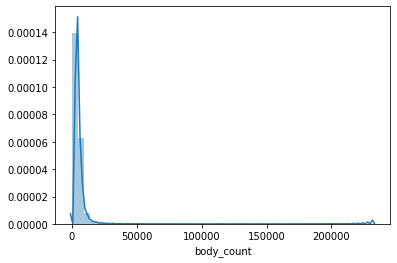

In [ ]:
# Word count in papers after removing stop words
sns.distplot(dfEnglish['body_count'])

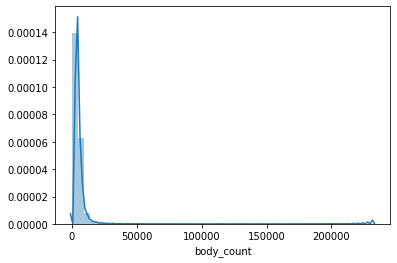

In [ ]:
# Unique words
sns.distplot(dfEnglish['body_count'])

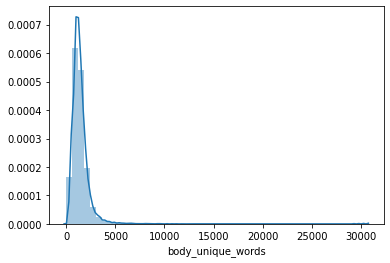

In [ ]:
sns.distplot(dfEnglish['body_unique_words'])

In [ ]:
# We are taking small dataset beacause training such huge dataset is not possible. 
# So we taking 1100 records rather than 33,000.
# dfEnglish = dfEnglish[:1100]

In [ ]:
dfEnglish.shape

(33183, 14)

In [ ]:
# Create vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(data, maxFeature):
    vectorize = TfidfVectorizer(maxFeature)
    return vectorize.fit_transform(data)

In [ ]:
text = dfEnglish['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(33183, 723591)

In [ ]:
# We have to remove some of the data and reducee some dimensions
from sklearn.decomposition import PCA
# We have tp select some components and random state will be tuned according to the time and cores
# As you increase the number of cores it will take some more time painfully, there is more chance that 
# it will take hours
pca = PCA(n_components=0.5, random_state= 42)
xReduce =  pca.fit_transform(X.toarray())
xReduce.shape

In [ ]:
# Now we enters in the final stage of our NLP project 
# We are going to build classification model using KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [ ]:
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(xReduce)
    k_means.fit(xReduce)
    distortions.append(sum(np.min(cdist(xReduce, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(xReduce)
dfEnglish['y'] = y_pred

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1100 samples in 8.796s...
[t-SNE] Computed neighbors for 1100 samples in 193.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1100
[t-SNE] Computed conditional probabilities for sample 1100 / 1100
[t-SNE] Mean sigma: 0.306233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.323605
[t-SNE] KL divergence after 1000 iterations: 1.159416


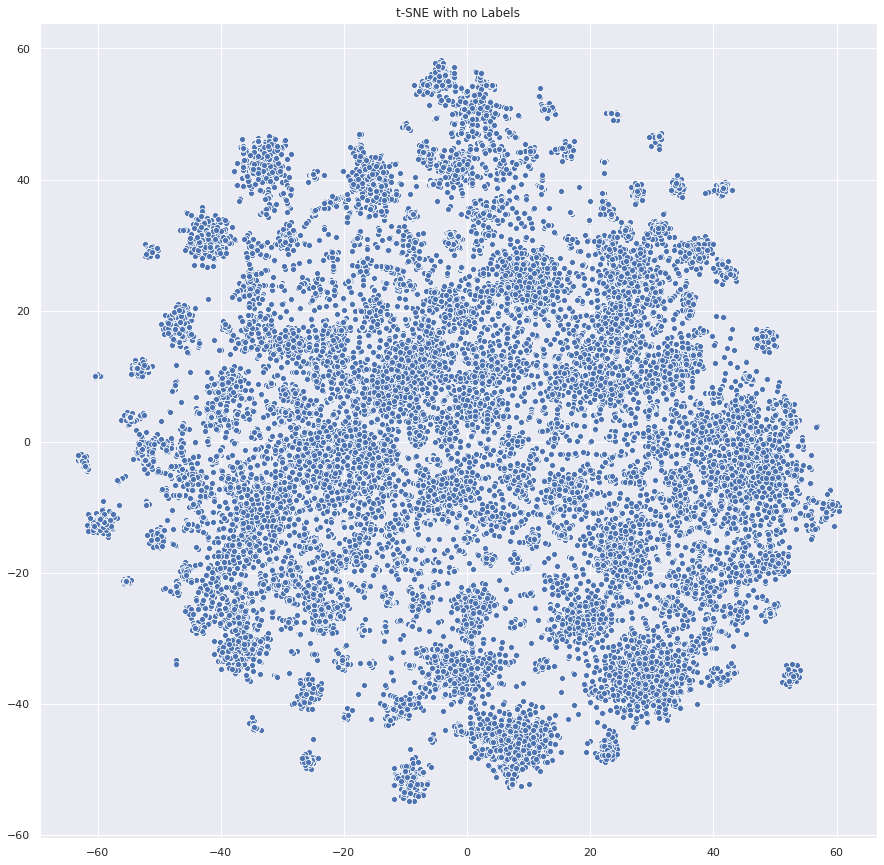

In [ ]:
from numpy import genfromtxt
X_embedded = genfromtxt('/content/drive/My Drive/xembedded.csv', delimiter=',')
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("./t-sne_covid19.png")
plt.show()

In [ ]:
print('Hello')

Hello


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/finalData.csv')

y_pred = data['y']
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 15)})
palette = sns.hls_palette(20, l=.4, s=.9)
# Different colors for differnet categories
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("./improved_cluster_tsne.png")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored

In [ ]:
# X = genfromtxt('/content/drive/My Drive/xtoarray.csv', delimiter=',')
# Importing train test split module
from sklearn.model_selection import train_test_split
# Test dataset is kept as 20% of whole data
X_train, X_test, y_train, y_test = train_test_split(X,y_pred, test_size=0.2, random_state=42)
print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 26546
X_test size: 6637 



In [ ]:
def report(test, pred):
    # classification accuracy report
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    # Accuracy score
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    # Precision score
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    # Reecall score
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

We can always train different models to just check which will be best for data and iin future we can ingest more data and can get distinction.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
#Stochastic gradient descent
# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

NameError: ignored

In [ ]:
import pandas as pd
dfEnglish = pd.read_csv('/content/drive/My Drive/intermediate1.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
df = dfEnglish

In [ ]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(33183, 4096)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(33183, 2458)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y_all'] = y_pred

In [ ]:
df.head()

,Unnamed: 0,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstracrt_count,body_count,body_unique_words,languages,processed_text,y,y_all
0,1934,5e0c586f047ff909c8ed3fe171c8975a90608d08,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...,211,3824,1310,en,porcine epidemic diarrhea virus pedv belong al...,1,16
1,1935,1579fbff7af9b156c6f49fee0526e48f852ea460,10.1038/s41598-018-30356-2,"Currently, live-attenuated IBV vaccines are us...","Generation of rNDVs expressing S1, S2 or S pro...","Shirvani, Edris. Paldurai, Anandan. <br>Mano...",A Recombinant Newcastle Disease Virus (NDV)<b...,Sci Rep,"Currently, live-attenuated IBV vaccines are<b...",945,7372,1257,en,generation rndvs express s1 s2 s protein ibv e...,1,6
2,1936,e0668c4b793d0cad26639b070819334a94648123,10.3399/bjgpopen18x101493,NaN,The incidence of complete Achilles tendon rupt...,"Mughal, Faraz. Chew-Graham, Carolyn A. Saad...",‘Hajj: what it means for general practice’,BJGP Open,Not provided.,0,2972,1099,en,incidence complete achilles tendon rupture 18 ...,0,19
3,1937,38aa050ad79d8a1d7022c33535255ce9d47914e5,10.1371/journal.pntd.0002933,The new world arenavirus Junín virus (JUNV) is...,Arenaviruses are enveloped RNA viruses with bi...,"Huang, Cheng. Walker, Aida G.. Grant, Ashle...",Potent Inhibition of Junín Virus Infection by...,PLoS Negl Trop Dis,The new world arenavirus Junín virus (JUNV) i...,160,3194,1096,en,arenaviruses envelop rna virus bi segment nega...,1,14
4,1938,61722c462b054f36461375e96e502cbf22648c04,10.1038/s41598-019-45095-1,and subtropical countries and is a significant...,"In this study, the anti-dengue activity of nic...","Jung, Eunhye. Nam, Sangwoo. Oh, Hyeryeon. ...",Neutralization of Acidic Intracellular<br>Ves...,Sci Rep,and subtropical countries and is a significan...,897,4095,1238,en,study anti dengue activity niclosamide evaluat...,1,4


In [ ]:
y_pred = df['y'].to_numpy()

In [ ]:
# X = genfromtxt('/content/drive/My Drive/xtoarray.csv', delimiter=',')
# Importing train test split module
from sklearn.model_selection import train_test_split
# Test dataset is kept as 20% of whole data
X_train, X_test, y_train, y_test = train_test_split(X,y_pred, test_size=0.2, random_state=42)
# print("X_train size:", len(X_train))
# print("X_test size:", len(X_test), "\n")

In [ ]:
def report(test, pred):
    # classification accuracy report
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    # Accuracy score
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    # Precision score
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    # Reecall score
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
#Stochastic gradient descent
# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
report(y_train, sgd_pred)

Accuracy Score:  98.900 %
     Precision:  98.904 %
        Recall:  98.866 %
      F1 score:  98.885 %


In [ ]:
df.to_csv('/content/drive/My Drive/tester1.csv')

In [ ]:
X_train

<26546x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 16091280 stored elements in Compressed Sparse Row format>